In [1]:
#import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import nltk
import re
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split 

import tensorflow_hub as hub

In [2]:
num_of_words = 10000
data = pd.read_csv('Tweets.csv')
tweet_df = data[['text','airline_sentiment']]
tweet_df = tweet_df[tweet_df['airline_sentiment'] != 'neutral']
tweet = tweet_df['text'].values
tweet_df

,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive
...,...,...
14633,@AmericanAir my flight was Cancelled Flightled...,negative
14634,@AmericanAir right on cue with the delays👌,negative
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative


In [3]:
label = LabelEncoder().fit_transform(tweet_df['airline_sentiment'])
#label = tf.keras.utils.to_categorical(label)

In [4]:
doc = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(tweet)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(tweet[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    doc.append(document)


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokenizer = Tokenizer(num_words=num_of_words)
tokenizer.fit_on_texts(doc)

vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(doc)
padded_sequence = pad_sequences(encoded_docs, maxlen=33, padding='post')

vectorizer = CountVectorizer(max_features=1500)
X = vectorizer.fit(doc)
#X = vectorizer.transform(doc)
#pint(X.vocabulary_)
layer = tf.keras.layers.TextVectorization()
layer.adapt(doc)
vt = layer(doc).numpy()

data1 = tokenizer.word_counts
data1 = dict(data1)
df = pd.DataFrame(data1.items(), columns=['word', 'count'])
print(df)

#link = 'https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1' 
#embed = hub.load(link)
#vem = embed(doc).numpy()
#padded_sequence = pad_sequences(vem, maxlen=100, dtype='float32', padding='post')
print()
#print(vectorizer.get_feature_names())
#X[0]

                word  count
0      virginamerica    347
1               plus     46
2                you   3635
3                 ve    438
4              added     14
...              ...    ...
11892       function      1
11893       nocharge      1
11894     drw08djhai      1
11895           aire      1
11896       jlhalldc      1

[11897 rows x 2 columns]



In [6]:
X_train, X_test, y_train, y_test = train_test_split(vt, label, test_size=0.3, random_state=500) 
n_feature = X_train.shape[1] 
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) 
print(n_feature)

(8078, 33) (8078,) (3463, 33) (3463,)
33


In [7]:
embedding_vector_length = 128
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_shape=(n_feature,)))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 128)           1522944   
                                                                 
 dropout (Dropout)           (None, 33, 128)           0         
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,671,169
Trainable params: 1,671,169
Non-

In [9]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, metrics=['accuracy'], loss=tf.keras.losses.binary_crossentropy)

In [10]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
253/253 [==============================] - 28s 90ms/step - loss: 0.3589 - accuracy: 0.8571 - val_loss: 0.2236 - val_accuracy: 0.9148
Epoch 2/50
253/253 [==============================] - 24s 97ms/step - loss: 0.1614 - accuracy: 0.9460 - val_loss: 0.2370 - val_accuracy: 0.9278
Epoch 3/50
253/253 [==============================] - 25s 100ms/step - loss: 0.0825 - accuracy: 0.9724 - val_loss: 0.2628 - val_accuracy: 0.9215
Epoch 4/50
253/253 [==============================] - 21s 83ms/step - loss: 0.0453 - accuracy: 0.9858 - val_loss: 0.2815 - val_accuracy: 0.9137
Epoch 5/50
253/253 [==============================] - 27s 105ms/step - loss: 0.0252 - accuracy: 0.9922 - val_loss: 0.3498 - val_accuracy: 0.9111
Epoch 6/50
253/253 [==============================] - 22s 88ms/step - loss: 0.0205 - accuracy: 0.9933 - val_loss: 0.3721 - val_accuracy: 0.9160
Epoch 7/50
253/253 [==============================] - 19s 75ms/step - loss: 0.0217 - accuracy: 0.9939 - val_loss: 0.4216 - val_accurac

In [11]:
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %.3f' % acc)
print('Loss: %.3f' % loss)

109/109 [==============================] - 3s 25ms/step - loss: 0.6028 - accuracy: 0.9036
Accuracy: 0.904
Loss: 0.603


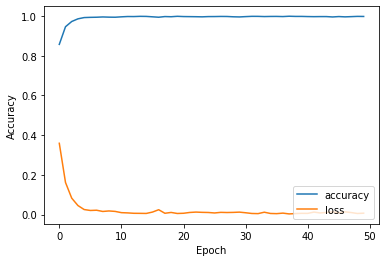

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim(0.6, 1.0)
plt.legend(loc='lower right')

In [13]:
def get_encode(x):
    encoded_docs = tokenizer.texts_to_sequences(x)
    padded_sequence = pad_sequences(encoded_docs, maxlen=n_feature, padding='post')
    return padded_sequence

def get_encode2(x):
    vt = layer(x).numpy()
    padded_sequence = pad_sequences(vt, maxlen=n_feature, padding='post')
    return padded_sequence

In [14]:
x = ['bad sevice is terrible', 'good idea', 'its better food than before', 'right on cue with the delays']
vec = get_encode2(x)
pred = model.predict(vec)
pred

array([[4.3410284e-07],
       [7.1875691e-01],
       [4.7088408e-01],
       [5.3521391e-05]], dtype=float32)